<a href="https://colab.research.google.com/github/simplifiedcomputing/weed_detection/blob/main/weed_detection_training.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weed Detection Training
Locate medical plants for human and animal health using object detection and classification.

## Install

- FastAI (training loop library)
- IceVision (computer vision framework)
- MMDetection and Yolo v5 (neural net models)

In [ ]:
!pip install openmim -q
!mim install mmcv-full
!mim install mmdet

!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] -U -q
!pip install git+git://github.com/airctic/icedata.git -U -q
!pip install yolov5-icevision -U -q 

In [ ]:
# Restart kernel after installation
exit()

## Imports
Import the required components.


In [ ]:
from icevision.all import *
from icevision.models.checkpoint import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Collect Data

Drone parameters for DJI MAVIC 2 Zoom

- (Autopilot)
- Hoover and Capture to minimize image distortion
- 5m flight altitude
- 5,5m capture distance (image size 7,1m x 5,5m at 5m altitude)  
- bright and windless weather conditions

## Prepare the Dataset

### Split image files
https://github.com/simplifiedcomputing/weed_detection/blob/main/weed_detection_split_images_for_training.ipynb

<a href="https://colab.research.google.com/github/simplifiedcomputing/weed_detection/blob/main/weed_detection_split_images_for_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Labeling for Drone collected data
Labeling in PascalVOC format with Annotation Tool

*   https://github.com/tzutalin/labelImg
*   https://github.com/openvinotoolkit/cvat
*   https://roboflow.com/

### Parse the dataset

The parser loads the annotation file and parses them returning a list of training and validation records. The parsers support multiple formats (including VOC and COCO).


#### Load Dataset

In [ ]:
# Set local data dir path
#data_dir = Path('/home/martin/projekte/herbst/data/image_herbst21_training_split')

In [ ]:
# or download dataset
url = "https://simplified-computing.de/weed_detection_split_data.zip"
dest_dir = "weed_detection_split_data"
data_dir = icedata.load_data(url, dest_dir)

  0%|          | 0/286654627 [00:00<?, ?B/s]

In [ ]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "annotations_herbst21_training_split", images_dir=data_dir / "image_herbst21_training_split")

#### Parse to create records

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

# idmap https://airctic.com/0.8.1/parser/
#myidmap = IDMap(["file1", "file2", "file3", "file4"])
#train_records, valid_records = parser.parse(idmap=myidmap)
#parser.class_map, parser.myidmap

  0%|          | 0/170 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/170 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'herbzeitlose': 1}>

### Explore Date

Using IceVision Dashboard

https://pypi.org/project/icevision-dashboards/

### Creating datasets with agumentations and transforms

To the training set we apply the Albumentation's default `aug_tfms`. It randomly applies broadly useful transformations including rotation, cropping, horizintal flips, and more. 

The validation set is only resized (with padding).

In [ ]:
# Transforms
# image_size divisible by 128
image_size = 1920
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

We then create `Datasets` for both. The dataset applies the transforms to the annotations (bounding boxes) and images in the data records.

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

#### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



## Creating a model
Selections only take two simple lines of code. For example, to try the mmdet library using the retinanet model and the resnet50_fpn_1x backbone  could be specified by:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.


In [ ]:
# Just change the value of selection to try another model

selection = 4

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.resnet50_fpn_mstrain_2x

elif selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }
  
elif selection == 2:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 3:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 4:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ultralytics.yolov5' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 {'img_size': 1920})

In [ ]:
backbone.__dict__

{'model_name': 'yolov5s'}

Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

  0%|          | 0.00/14.0M [00:00<?, ?B/s]

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=1, num_workers=1, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=1, num_workers=1, shuffle=False)

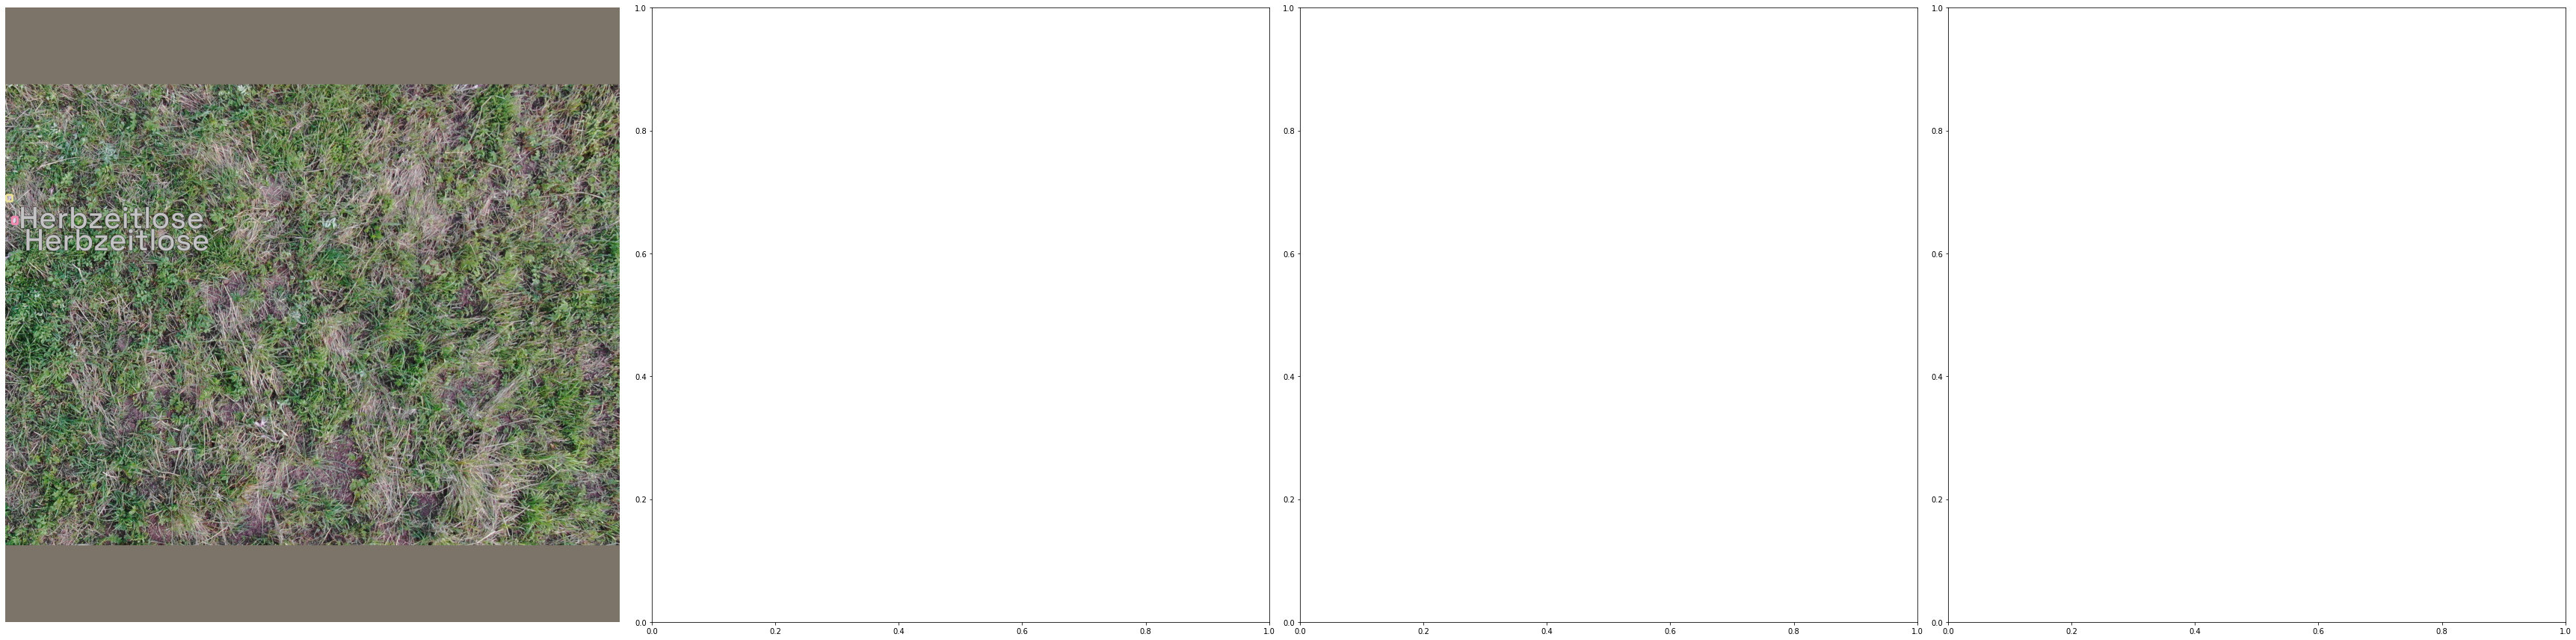

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai engine collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an easy to use computer vision framework plugged into DL learning engines such as [fastai2](https://github.com/fastai/fastai2).  


### Training using fastai

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(valley=0.02290867641568184)

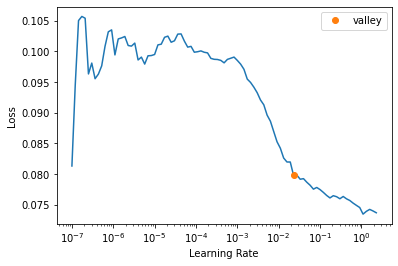

In [ ]:
learn.lr_find()

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.0229)

In [ ]:
learn.fine_tune(50, 0.0229, freeze_epochs=1)

## Showing results

From the validation dataset.

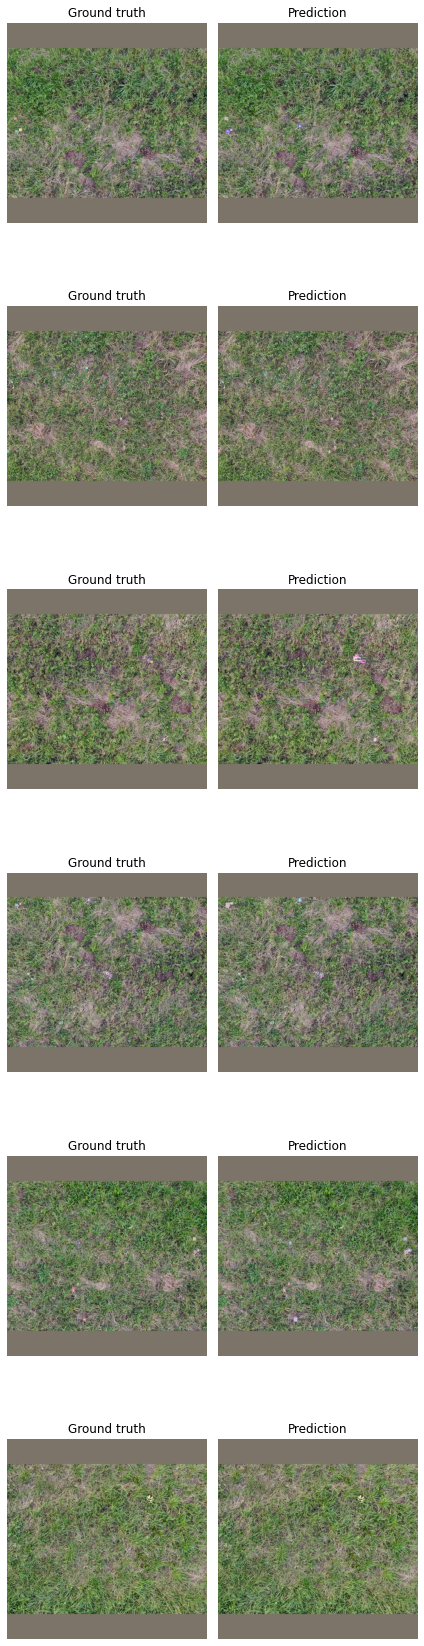

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.01)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True, detection_threshold=.01)

  0%|          | 0/9 [00:00<?, ?it/s]

Let´s take a look at the bboxes

In [ ]:
preds[1].pred.detection.bboxes

[<BBox (xmin:179.16905212402344, ymin:1250.4449462890625, xmax:210.23338317871094, ymax:1278.4022216796875)>]

For visualizing the predictions we can use show_preds:

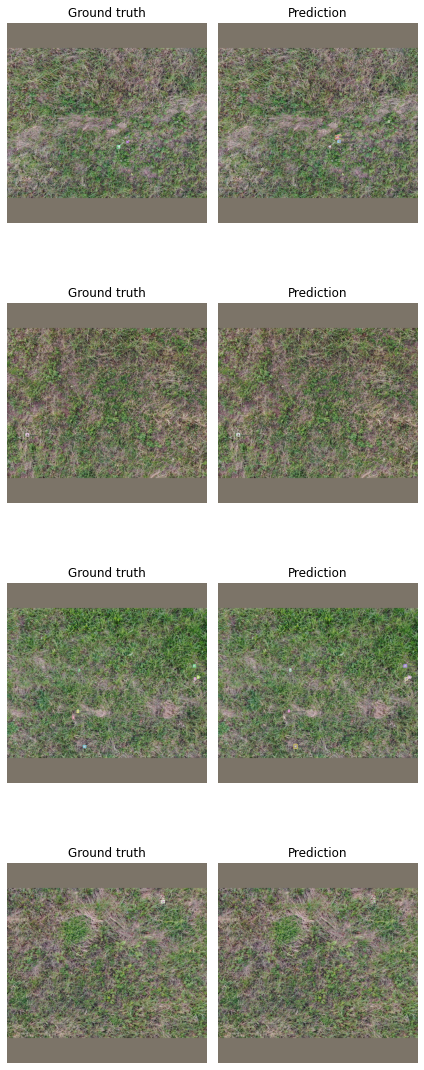

In [ ]:
show_preds(preds=preds[:4])

#Saving Parameters

In [ ]:
# Check icevision_version
!pip list | grep icevision

icevision                     0.10.0a1
yolov5-icevision              6.0.0


In [ ]:
# How to save a model and its metadata
checkpoint_path = 'weed_detection_split_checkpoint.pth'

save_icevision_checkpoint(model, 
                        model_name='ultralytics.yolov5', 
                        backbone_name='small',
                        classes = parser.class_map.get_classes(),
                        img_size = image_size, 
                        filename = checkpoint_path,
                        meta={'icevision_version': '0.10.0a1'})

# download checkpoint file
from google.colab import files
files.download('weed_detection_split_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>